# Big Data Project

### Max Rankins, Chris Pizza, Leon Chen

#### Twitter Scrapping useful links
https://github.com/Mottl/GetOldTweets3#egg=GetOldTweets3 

https://pypi.org/project/GetOldTweets3/ 

https://towardsdatascience.com/how-to-scrape-tweets-from-twitter-59287e20f0f1 




### Importing Spark and Creating Entry Point

In [ ]:
import os
#Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Set JAVA_HOME path variable in Linux
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version


#Install Spark
#download Spark file
!wget -q http://apache.osuosl.org/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
#extract the file
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
#Set SPARK-HOME path variable in Linux
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"


#install findspark package
!pip install -q findspark
import findspark
findspark.init()

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [ ]:
import findspark
findspark.init()

In [ ]:
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("lecture7").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

In [ ]:
# Any Imports I might Need
from pyspark.sql.types import *
from pyspark.sql.functions import udf, expr, concat, col, UserDefinedFunction, monotonically_increasing_id
from pyspark.sql.functions import *
spark = SparkSession.builder.appName('aggs').getOrCreate()
import pprint
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

## Reading in Data

In [ ]:
#read the data
from google.colab import drive
drive.mount('/content/drive')

cnn = spark.read.csv("CNN.csv", inferSchema=True, header=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Looking at Data

In [ ]:
cnn.head(5)

[Row(date='7/21/2020 4:01', username='CNN', replies=480, retweets=864, favorites=2221, text='Portland Mayor Ted Wheeler says the tactics of camouflaged federal authorities deployed to protests in his city “are unconstitutional,” adding that “in the United States you still have to have probable cause. People still have their rights and those rights seem to be trampled on""'),
 Row(date='7/21/2020 3:31', username='CNN', replies=146, retweets=441, favorites=1170, text='"""If President Trump is right about anything'),
 Row(date='7/21/2020 3:21', username='CNN', replies=224, retweets=790, favorites=2425, text='“I don’t think he is reacting to the real carnage occurring across the United States. I think he is reacting to his plummeting poll numbers.” Dr. Jonathan Reiner, former White House medical adviser on President Trump resuming daily coronavirus briefings http://cnn.it/32DcDJl'),
 Row(date='7/21/2020 2:23', username='CNN', replies=137, retweets=756, favorites=2122, text="Coronavirus won

In [ ]:
cnn.printSchema()

root
 |-- date: string (nullable = true)
 |-- username: string (nullable = true)
 |-- replies: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
cnn.show(5)

+---------------+--------+-------+--------+---------+--------------------+
|           date|username|replies|retweets|favorites|                text|
+---------------+--------+-------+--------+---------+--------------------+
| 7/21/2020 4:01|     CNN|    480|     864|     2221|Portland Mayor Te...|
| 7/21/2020 3:31|     CNN|    146|     441|     1170|"""If President T...|
| 7/21/2020 3:21|     CNN|    224|     790|     2425|“I don’t think he...|
| 7/21/2020 2:23|     CNN|    137|     756|     2122|Coronavirus won’t...|
|7/20/2020 23:21|     CNN|    875|     562|     2845|The Missouri coup...|
+---------------+--------+-------+--------+---------+--------------------+
only showing top 5 rows



## Removing Unneed Infomation

In [ ]:
# I've made the choice to drop nulls 
print((cnn.count(), len(cnn.columns)))

(14194, 6)


In [ ]:
cnn.na.drop().show(5)

+---------------+--------+-------+--------+---------+--------------------+
|           date|username|replies|retweets|favorites|                text|
+---------------+--------+-------+--------+---------+--------------------+
| 7/21/2020 4:01|     CNN|    480|     864|     2221|Portland Mayor Te...|
| 7/21/2020 3:31|     CNN|    146|     441|     1170|"""If President T...|
| 7/21/2020 3:21|     CNN|    224|     790|     2425|“I don’t think he...|
| 7/21/2020 2:23|     CNN|    137|     756|     2122|Coronavirus won’t...|
|7/20/2020 23:21|     CNN|    875|     562|     2845|The Missouri coup...|
+---------------+--------+-------+--------+---------+--------------------+
only showing top 5 rows



In [ ]:
# Well it seems like there where no null values
print((cnn.count(), len(cnn.columns)))

(14194, 6)


## Centering Numerical Columns in Data (replies, retweet, favorites)

In [ ]:
cnn.show(5)

+---------------+--------+-------+--------+---------+--------------------+
|           date|username|replies|retweets|favorites|                text|
+---------------+--------+-------+--------+---------+--------------------+
| 7/21/2020 4:01|     CNN|    480|     864|     2221|Portland Mayor Te...|
| 7/21/2020 3:31|     CNN|    146|     441|     1170|"""If President T...|
| 7/21/2020 3:21|     CNN|    224|     790|     2425|“I don’t think he...|
| 7/21/2020 2:23|     CNN|    137|     756|     2122|Coronavirus won’t...|
|7/20/2020 23:21|     CNN|    875|     562|     2845|The Missouri coup...|
+---------------+--------+-------+--------+---------+--------------------+
only showing top 5 rows



In [ ]:
## Average number of repplies for the 14200 tweets
cnn.agg({'replies': 'mean'}).show()

+------------------+
|      avg(replies)|
+------------------+
|231.83077356629562|
+------------------+



In [ ]:
# Centering the replies column
cnn =  cnn.withColumn("replies", expr("replies - 232").cast("integer"))
cnn.show(6)

+---------------+--------+-------+--------+---------+--------------------+
|           date|username|replies|retweets|favorites|                text|
+---------------+--------+-------+--------+---------+--------------------+
| 7/21/2020 4:01|     CNN|    248|     864|     2221|Portland Mayor Te...|
| 7/21/2020 3:31|     CNN|    -86|     441|     1170|"""If President T...|
| 7/21/2020 3:21|     CNN|     -8|     790|     2425|“I don’t think he...|
| 7/21/2020 2:23|     CNN|    -95|     756|     2122|Coronavirus won’t...|
|7/20/2020 23:21|     CNN|    643|     562|     2845|The Missouri coup...|
|7/20/2020 16:50|     CNN|    366|     998|     1616|The person suspec...|
+---------------+--------+-------+--------+---------+--------------------+
only showing top 6 rows



In [ ]:
# Average number of retweets for the 14200 tweets
cnn.agg({'retweets': 'mean'}).show()

+------------------+
|     avg(retweets)|
+------------------+
|498.99380019726647|
+------------------+



In [ ]:
# Centering the retweets column
cnn = cnn.withColumn("retweets", expr("retweets - 499").cast("integer"))
cnn.show(6)

+---------------+--------+-------+--------+---------+--------------------+
|           date|username|replies|retweets|favorites|                text|
+---------------+--------+-------+--------+---------+--------------------+
| 7/21/2020 4:01|     CNN|    248|     365|     2221|Portland Mayor Te...|
| 7/21/2020 3:31|     CNN|    -86|     -58|     1170|"""If President T...|
| 7/21/2020 3:21|     CNN|     -8|     291|     2425|“I don’t think he...|
| 7/21/2020 2:23|     CNN|    -95|     257|     2122|Coronavirus won’t...|
|7/20/2020 23:21|     CNN|    643|      63|     2845|The Missouri coup...|
|7/20/2020 16:50|     CNN|    366|     499|     1616|The person suspec...|
+---------------+--------+-------+--------+---------+--------------------+
only showing top 6 rows



In [ ]:
# Average number of facorites for hte 14200 tweets
cnn.agg({'favorites': 'mean'}).show()

+------------------+
|    avg(favorites)|
+------------------+
|1814.5133859377202|
+------------------+



In [ ]:
# Centering the favorites column
cnn = cnn.withColumn("favorites", expr("favorites - 1815").cast("integer"))
cnn.show(6)

+---------------+--------+-------+--------+---------+--------------------+
|           date|username|replies|retweets|favorites|                text|
+---------------+--------+-------+--------+---------+--------------------+
| 7/21/2020 4:01|     CNN|    248|     365|      406|Portland Mayor Te...|
| 7/21/2020 3:31|     CNN|    -86|     -58|     -645|"""If President T...|
| 7/21/2020 3:21|     CNN|     -8|     291|      610|“I don’t think he...|
| 7/21/2020 2:23|     CNN|    -95|     257|      307|Coronavirus won’t...|
|7/20/2020 23:21|     CNN|    643|      63|     1030|The Missouri coup...|
|7/20/2020 16:50|     CNN|    366|     499|     -199|The person suspec...|
+---------------+--------+-------+--------+---------+--------------------+
only showing top 6 rows



## Cleaning Tweets P1 Removing Puncation

In [ ]:
# Some help from stack overflow
# https://stackoverflow.com/questions/58038919/removing-punctuation-in-spark-dataframe 
def removePunctuation(column):
    # I couldnt find a work around but you shouldnt do this
    cleanTextHold =  trim(lower(regexp_replace(concat_ws("text", column),'[^\sa-zA-Z0-9]', ''))).alias("cleanText")
    return cleanTextHold

In [ ]:
# Remove all the puncuation in the string
ok = cnn.select(removePunctuation(('text')))
ok.show(6)

+--------------------+
|           cleanText|
+--------------------+
|portland mayor te...|
|if president trum...|
|i dont think he i...|
|coronavirus wont ...|
|the missouri coup...|
|the person suspec...|
+--------------------+
only showing top 6 rows



In [ ]:
ok.printSchema()

root
 |-- cleanText: string (nullable = false)



In [ ]:
ok = ok.select(split(col("cleanText")," "))

In [ ]:
ok = ok.withColumnRenamed("split(cleanText,  )","cleanText")

In [ ]:
ok.show(5)

+--------------------+
|           cleanText|
+--------------------+
|[portland, mayor,...|
|[if, president, t...|
|[i, dont, think, ...|
|[coronavirus, won...|
|[the, missouri, c...|
+--------------------+
only showing top 5 rows



In [ ]:
ok = ok.withColumn("cleanText", ok["cleanText"].cast(StringType()))


In [ ]:
ok.printSchema()

root
 |-- cleanText: string (nullable = false)



In [ ]:
ok.show(3)

+--------------------+
|           cleanText|
+--------------------+
|[portland, mayor,...|
|[if, president, t...|
|[i, dont, think, ...|
+--------------------+
only showing top 3 rows



In [ ]:
# Creating Id column to join on 
cnn = cnn.select("*").withColumn("id", monotonically_increasing_id())
cnn.show(5)

+---------------+--------+-------+--------+---------+--------------------+---+
|           date|username|replies|retweets|favorites|                text| id|
+---------------+--------+-------+--------+---------+--------------------+---+
| 7/21/2020 4:01|     CNN|    248|     365|      406|Portland Mayor Te...|  0|
| 7/21/2020 3:31|     CNN|    -86|     -58|     -645|"""If President T...|  1|
| 7/21/2020 3:21|     CNN|     -8|     291|      610|“I don’t think he...|  2|
| 7/21/2020 2:23|     CNN|    -95|     257|      307|Coronavirus won’t...|  3|
|7/20/2020 23:21|     CNN|    643|      63|     1030|The Missouri coup...|  4|
+---------------+--------+-------+--------+---------+--------------------+---+
only showing top 5 rows



In [ ]:
# Creating Id Column to join on
ok = ok.select("*").withColumn("id", monotonically_increasing_id())
ok.show(5)

+--------------------+---+
|           cleanText| id|
+--------------------+---+
|[portland, mayor,...|  0|
|[if, president, t...|  1|
|[i, dont, think, ...|  2|
|[coronavirus, won...|  3|
|[the, missouri, c...|  4|
+--------------------+---+
only showing top 5 rows



In [ ]:
# Combine the 2 data frames into one based on the id column
cnn = cnn.join(ok, on=['id'], how='left_outer')
cnn.show(5)

+---+---------------+--------+-------+--------+---------+--------------------+--------------------+
| id|           date|username|replies|retweets|favorites|                text|           cleanText|
+---+---------------+--------+-------+--------+---------+--------------------+--------------------+
|  0| 7/21/2020 4:01|     CNN|    248|     365|      406|Portland Mayor Te...|[portland, mayor,...|
|  1| 7/21/2020 3:31|     CNN|    -86|     -58|     -645|"""If President T...|[if, president, t...|
|  2| 7/21/2020 3:21|     CNN|     -8|     291|      610|“I don’t think he...|[i, dont, think, ...|
|  3| 7/21/2020 2:23|     CNN|    -95|     257|      307|Coronavirus won’t...|[coronavirus, won...|
|  4|7/20/2020 23:21|     CNN|    643|      63|     1030|The Missouri coup...|[the, missouri, c...|
+---+---------------+--------+-------+--------+---------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Drop Columns old text column and the date column
cnn = cnn.drop("text")
cnn = cnn.drop("id")
cnn = cnn.drop("date")

In [ ]:
cnn.show(5)

+--------+-------+--------+---------+--------------------+
|username|replies|retweets|favorites|           cleanText|
+--------+-------+--------+---------+--------------------+
|     CNN|    248|     365|      406|[portland, mayor,...|
|     CNN|    -86|     -58|     -645|[if, president, t...|
|     CNN|     -8|     291|      610|[i, dont, think, ...|
|     CNN|    -95|     257|      307|[coronavirus, won...|
|     CNN|    643|      63|     1030|[the, missouri, c...|
+--------+-------+--------+---------+--------------------+
only showing top 5 rows



In [ ]:
cnn.printSchema()

root
 |-- username: string (nullable = true)
 |-- replies: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- cleanText: string (nullable = true)



## Massage tweets some more

## Creating a new row from each of the elements in the array in the cleanText column

In [ ]:
# https://stackoverflow.com/questions/57066797/pyspark-dataframe-split-column-with-multiple-values-into-rows
cnn = cnn.withColumn("cleanText", explode(split(regexp_replace(col("cleanText"), "(^\[)|(\]$)", ""), ", ")))
cnn.show(5)

+--------+-------+--------+---------+---------+
|username|replies|retweets|favorites|cleanText|
+--------+-------+--------+---------+---------+
|     CNN|    248|     365|      406| portland|
|     CNN|    248|     365|      406|    mayor|
|     CNN|    248|     365|      406|      ted|
|     CNN|    248|     365|      406|  wheeler|
|     CNN|    248|     365|      406|     says|
+--------+-------+--------+---------+---------+
only showing top 5 rows



In [ ]:
print((cnn.count(), len(cnn.columns)))

(412089, 5)


In [ ]:
cnn.printSchema()

root
 |-- username: string (nullable = true)
 |-- replies: integer (nullable = true)
 |-- retweets: integer (nullable = true)
 |-- favorites: integer (nullable = true)
 |-- cleanText: string (nullable = true)



In [ ]:
cnn = cnn.groupBy('cleanText').mean()
cnn.show(5)

+---------+-------------------+------------------+-------------------+
|cleanText|       avg(replies)|     avg(retweets)|     avg(favorites)|
+---------+-------------------+------------------+-------------------+
|    still|-56.194117647058825|-49.07058823529412|-387.36470588235295|
|    those| 22.606965174129353| 256.2487562189055|  349.2786069651741|
|     hope| -24.29090909090909|-82.34545454545454|-38.763636363636365|
|   online| 113.59420289855072| 4.608695652173913|  -74.3913043478261|
|     some|-13.457786116322701|-83.51969981238274|-313.77110694183864|
+---------+-------------------+------------------+-------------------+
only showing top 5 rows



In [ ]:
# Weird more Data Cleaning I guess ... 
cnn.orderBy(cnn['avg(retweets)'].desc()).show(10)

+-----------------+------------+-------------+--------------+
|        cleanText|avg(replies)|avg(retweets)|avg(favorites)|
+-----------------+------------+-------------+--------------+
|httpscnnit2algl9s|     13731.0|     120050.0|      226792.0|
|            elmos|      1583.0|      63084.0|      145194.0|
|httpscnnit2ajcvoe|      1807.0|      34299.0|       61542.0|
|          jimenez|      2995.0|      27629.0|       65682.0|
|httpscnnit36s5hib|      2995.0|      27629.0|       65682.0|
|          freeman|      4178.0|      27054.0|       70848.0|
|httpscnnit2znutod|      4178.0|      27054.0|       70848.0|
|httpscnnit2zmtg6i|       414.0|      25896.0|       81129.0|
|      militaryled|        29.0|      19337.5|        5448.0|
|        thailands|        29.0|      19337.5|        5448.0|
+-----------------+------------+-------------+--------------+
only showing top 10 rows



In [ ]:
cnn = cnn.filter(~(cnn.cleanText.contains('https')))
cnn.show(5)

+---------+-------------------+------------------+-------------------+
|cleanText|       avg(replies)|     avg(retweets)|     avg(favorites)|
+---------+-------------------+------------------+-------------------+
|    still|-56.194117647058825|-49.07058823529412|-387.36470588235295|
|    those| 22.606965174129353| 256.2487562189055|  349.2786069651741|
|     hope| -24.29090909090909|-82.34545454545454|-38.763636363636365|
|   online| 113.59420289855072| 4.608695652173913|  -74.3913043478261|
|     some|-13.457786116322701|-83.51969981238274|-313.77110694183864|
+---------+-------------------+------------------+-------------------+
only showing top 5 rows



In [ ]:
print((cnn.count(), len(cnn.columns)))

(20350, 4)


In [ ]:
# Removing all rows that did not have an odd number of replies, retweets, favorites
cnn = cnn.filter((cnn['avg(replies)']%1) != 0)
cnn = cnn.filter((cnn['avg(retweets)']%1) != 0)
cnn = cnn.filter((cnn['avg(favorites)']%1) != 0) 

print((cnn.count(), len(cnn.columns)))
cnn.show(5)

(6956, 4)
+---------+-------------------+------------------+-------------------+
|cleanText|       avg(replies)|     avg(retweets)|     avg(favorites)|
+---------+-------------------+------------------+-------------------+
|    still|-56.194117647058825|-49.07058823529412|-387.36470588235295|
|    those| 22.606965174129353| 256.2487562189055|  349.2786069651741|
|     hope| -24.29090909090909|-82.34545454545454|-38.763636363636365|
|   online| 113.59420289855072| 4.608695652173913|  -74.3913043478261|
|     some|-13.457786116322701|-83.51969981238274|-313.77110694183864|
+---------+-------------------+------------------+-------------------+
only showing top 5 rows



In [ ]:
cnn = cnn.filter((cnn['avg(replies)']%1) != 0.5)
cnn = cnn.filter((cnn['avg(retweets)']%1) != 0.5)
cnn = cnn.filter((cnn['avg(favorites)']%1) != 0.5)

cnn = cnn.filter((cnn['avg(replies)']%1) != -0.5)
cnn = cnn.filter((cnn['avg(retweets)']%1) != -0.5)
cnn = cnn.filter((cnn['avg(favorites)']%1) != -0.5)

cnn = cnn.filter((cnn['avg(replies)']%1) != (1/3))
cnn = cnn.filter((cnn['avg(retweets)']%1) != (1/3))
cnn = cnn.filter((cnn['avg(favorites)']%1) != (1/3))

cnn = cnn.filter((cnn['avg(replies)']%1) != (-1/3))
cnn = cnn.filter((cnn['avg(retweets)']%1) != (-1/3))
cnn = cnn.filter((cnn['avg(favorites)']%1) != (-1/3))

cnn = cnn.filter((cnn['avg(replies)']%1) != 0.25)
cnn = cnn.filter((cnn['avg(retweets)']%1) != 0.25)
cnn = cnn.filter((cnn['avg(favorites)']%1) != 0.25)

cnn = cnn.filter((cnn['avg(replies)']%1) != -0.25)
cnn = cnn.filter((cnn['avg(retweets)']%1) != -0.25)
cnn = cnn.filter((cnn['avg(favorites)']%1) != -0.25)

cnn = cnn.filter((cnn['avg(replies)']%1) != 0.4)
cnn = cnn.filter((cnn['avg(retweets)']%1) != 0.4)
cnn = cnn.filter((cnn['avg(favorites)']%1) != 0.4)

cnn = cnn.filter((cnn['avg(replies)']%1) != -0.4)
cnn = cnn.filter((cnn['avg(retweets)']%1) != -0.4)
cnn = cnn.filter((cnn['avg(favorites)']%1) != -0.4)

cnn = cnn.filter((cnn['avg(replies)']%1) != 0.2)
cnn = cnn.filter((cnn['avg(retweets)']%1) != 0.2)
cnn = cnn.filter((cnn['avg(favorites)']%1) != 0.2)

cnn = cnn.filter((cnn['avg(replies)']%1) != -0.2)
cnn = cnn.filter((cnn['avg(retweets)']%1) != -0.2)
cnn = cnn.filter((cnn['avg(favorites)']%1) != -0.2)

cnn = cnn.filter((cnn['avg(replies)']%1) != (.66666666666666))
cnn = cnn.filter((cnn['avg(retweets)']%1) != (.66666666666666))
cnn = cnn.filter((cnn['avg(favorites)']%1) != (.66666666666666))

cnn = cnn.filter((cnn['avg(replies)']%1) != (-.66666666666666))
cnn = cnn.filter((cnn['avg(retweets)']%1) != (-.66666666666666))
cnn = cnn.filter((cnn['avg(favorites)']%1) != (-.66666666666666))

print((cnn.count(), len(cnn.columns)))
cnn.show(5)

(5336, 4)
+---------+-------------------+------------------+-------------------+
|cleanText|       avg(replies)|     avg(retweets)|     avg(favorites)|
+---------+-------------------+------------------+-------------------+
|    still|-56.194117647058825|-49.07058823529412|-387.36470588235295|
|    those| 22.606965174129353| 256.2487562189055|  349.2786069651741|
|     hope| -24.29090909090909|-82.34545454545454|-38.763636363636365|
|   online| 113.59420289855072| 4.608695652173913|  -74.3913043478261|
|     some|-13.457786116322701|-83.51969981238274|-313.77110694183864|
+---------+-------------------+------------------+-------------------+
only showing top 5 rows



## Displaying most "popular words"

In [ ]:
# Common words in tweets that got the most favorites (hearts/likes)
cnn.orderBy(cnn['avg(favorites)'].desc()).show(20)

+------------+-------------------+------------------+------------------+
|   cleanText|       avg(replies)|     avg(retweets)|    avg(favorites)|
+------------+-------------------+------------------+------------------+
|  astonishes| 1667.6666666666667|1520.6666666666667|16888.333333333332|
|        hugh| 221.66666666666666|1857.8333333333333|15338.166666666666|
|    explains| 119.33333333333333| 6815.888888888889|15288.111111111111|
|     bullied| 191.28571428571428|1745.4285714285713| 14408.42857142857|
|      nephew|-32.333333333333336|2144.6666666666665|13502.666666666666|
|       genoa|-32.333333333333336|2144.6666666666665|13502.666666666666|
|    reporter|  937.2631578947369|6334.0526315789475|13161.157894736842|
|       grass|  2.142857142857143| 1731.857142857143| 12312.57142857143|
|     turtles| -79.26315789473684|3263.7368421052633|11453.736842105263|
|     thanked| 491.38461538461536|2022.3076923076924|10985.307692307691|
|    lounging|-50.666666666666664|1204.666666666666

In [ ]:
# Common words in tweets that got the most retweets

# This one was interesting

cnn.orderBy(cnn['avg(retweets)'].desc()).show(20)

+---------------+------------------+------------------+------------------+
|      cleanText|      avg(replies)|     avg(retweets)|    avg(favorites)|
+---------------+------------------+------------------+------------------+
|       explains|119.33333333333333| 6815.888888888889|15288.111111111111|
|       reporter| 937.2631578947369|6334.0526315789475|13161.157894736842|
|         arrest| 551.5714285714286| 4659.457142857143| 9472.485714285714|
|   semiofficial|            1463.4|            4124.2|            7953.6|
|        turtles|-79.26315789473684|3263.7368421052633|11453.736842105263|
|     protesting|             111.9|           3192.45|            7416.3|
|         camera|           270.725|          3011.075|            5664.9|
|       rerouted|1982.6666666666667|2929.6666666666665|2238.3333333333335|
|  bakarisellers|27.333333333333332|2720.6666666666665| 7366.666666666667|
|    minneapolis| 321.2980769230769| 2692.798076923077| 5944.326923076923|
|cnnsesamestreet|-35.2307

In [ ]:
# Common words in tweets that got the most replies
cnn.orderBy(cnn['avg(replies)'].desc()).show(20)

+------------+------------------+-------------------+-------------------+
|   cleanText|      avg(replies)|      avg(retweets)|     avg(favorites)|
+------------+------------------+-------------------+-------------------+
|       qanon| 7970.666666666667| 1696.3333333333333|  4968.666666666667|
|    stanford|2998.6666666666665|-115.66666666666667|-212.66666666666666|
|    baseless|2767.6666666666665|  623.3333333333334| 1456.6666666666667|
|antimalarial|2764.6363636363635|  2051.181818181818| 3205.6363636363635|
|      darker|2421.3333333333335| 155.66666666666666|-10.666666666666666|
|    staterun|2060.1428571428573| 216.28571428571428| 21.857142857142858|
|     burgers|1998.2857142857142|-15.857142857142858| 181.14285714285714|
|    rerouted|1982.6666666666667| 2929.6666666666665| 2238.3333333333335|
|       elite|            1869.6|              117.2|              466.4|
|     channel|1705.2222222222222|-130.55555555555554| -329.1111111111111|
|   murkowski|            1703.2|     

In [ ]:
# Common words in tweets that got the LEAST favorites (hearts/likes)
cnn.orderBy(cnn['avg(favorites)']).show(20)

+---------------+-------------------+-------------------+-------------------+
|      cleanText|       avg(replies)|      avg(retweets)|     avg(favorites)|
+---------------+-------------------+-------------------+-------------------+
|        measles| -200.9090909090909|-391.27272727272725|-1630.6363636363637|
|       ravaging|-197.66666666666666| -378.6666666666667|-1577.3333333333333|
|      honeybees|-187.66666666666666| -391.3333333333333|-1564.3333333333333|
|       specimen|-187.66666666666666| -391.3333333333333|-1564.3333333333333|
|      antitrust|-209.33333333333334| -396.3333333333333|-1537.6666666666667|
|           ar15|-161.66666666666666| -337.3333333333333|-1533.6666666666667|
|          aston|-202.66666666666666| -415.6666666666667|-1524.6666666666667|
|      exchanges|-160.33333333333334| -337.3333333333333|-1523.3333333333333|
|         washer|-129.66666666666666| -336.3333333333333|-1522.6666666666667|
|      furniture|-129.66666666666666| -336.3333333333333|-1522.6

In [ ]:
# Common words in tweets that got the LEAST retweets
cnn.orderBy(cnn['avg(retweets)']).show(20)

+-----------------+-------------------+-------------------+-------------------+
|        cleanText|       avg(replies)|      avg(retweets)|     avg(favorites)|
+-----------------+-------------------+-------------------+-------------------+
|          sheeran|            -199.75|            -427.75|           -1502.75|
|            fungi|-199.33333333333334| -427.6666666666667|-1520.6666666666667|
|         veronica|-208.66666666666666| -425.6666666666667|-1377.3333333333333|
|       backenstoe|-208.66666666666666| -425.6666666666667|-1377.3333333333333|
|           ronnie|-208.66666666666666| -425.6666666666667|-1377.3333333333333|
|          porsche|-157.66666666666666| -419.6666666666667|-1507.6666666666667|
|           taycan|-157.66666666666666| -419.6666666666667|-1507.6666666666667|
|       newtonjohn|-216.16666666666666| -417.3333333333333|-1341.6666666666667|
|            aston|-202.66666666666666| -415.6666666666667|-1524.6666666666667|
|         wresting|-192.66666666666666| 

In [ ]:
# Common words in tweets that got the LEAST replies
cnn.orderBy(cnn['avg(replies)']).show(20)

+---------------+-------------------+-------------------+-------------------+
|      cleanText|       avg(replies)|      avg(retweets)|     avg(favorites)|
+---------------+-------------------+-------------------+-------------------+
|        prowled|-217.33333333333334| -381.6666666666667|-1459.6666666666667|
|       leopards|-217.33333333333334| -381.6666666666667|-1459.6666666666667|
|        revived|-217.16666666666666| -401.8333333333333|-1328.3333333333333|
|   birdseyeview|-216.66666666666666| -268.1666666666667| -892.1666666666666|
|       dazzling|             -216.4|             -357.6|            -1240.6|
|     quadrantid|             -216.4|             -357.6|            -1240.6|
|     newtonjohn|-216.16666666666666| -417.3333333333333|-1341.6666666666667|
|          macys|           -213.625|           -407.875|          -1363.375|
|conservationist|             -212.2|             -372.6|            -1493.2|
|         grease|-211.91666666666666| -405.3333333333333|-1321.6

# Word Cloud for CNN

In [ ]:
cnn = cnn.orderBy(cnn['avg(retweets)'].desc())
cnn.show(20)

+---------------+------------------+------------------+------------------+
|      cleanText|      avg(replies)|     avg(retweets)|    avg(favorites)|
+---------------+------------------+------------------+------------------+
|       explains|119.33333333333333| 6815.888888888889|15288.111111111111|
|       reporter| 937.2631578947369|6334.0526315789475|13161.157894736842|
|         arrest| 551.5714285714286| 4659.457142857143| 9472.485714285714|
|   semiofficial|            1463.4|            4124.2|            7953.6|
|        turtles|-79.26315789473684|3263.7368421052633|11453.736842105263|
|     protesting|             111.9|           3192.45|            7416.3|
|         camera|           270.725|          3011.075|            5664.9|
|       rerouted|1982.6666666666667|2929.6666666666665|2238.3333333333335|
|  bakarisellers|27.333333333333332|2720.6666666666665| 7366.666666666667|
|    minneapolis| 321.2980769230769| 2692.798076923077| 5944.326923076923|
|cnnsesamestreet|-35.2307

In [65]:
# Getting to first 
cleanText_list = cnn.select('cleanText').take(100)
cleanText_array = [str(row.cleanText) for row in cleanText_list]

In [66]:
cleanText_list[:5]

[Row(cleanText='explains'),
 Row(cleanText='reporter'),
 Row(cleanText='arrest'),
 Row(cleanText='semiofficial'),
 Row(cleanText='turtles')]

In [67]:
# List of strings for the words
cleanText_array[:5]

['explains', 'reporter', 'arrest', 'semiofficial', 'turtles']

In [68]:
cnn = cnn.withColumnRenamed("avg(retweets)","avg_retweets")
cnn.printSchema()

root
 |-- cleanText: string (nullable = true)
 |-- avg(replies): double (nullable = true)
 |-- avg_retweets: double (nullable = true)
 |-- avg(favorites): double (nullable = true)



In [69]:
avg_retweets_list = cnn.select('avg_retweets').take(100)
avg_retweets_array = [int(row.avg_retweets) for row in avg_retweets_list]

In [70]:
avg_retweets_list[:5]

[Row(avg_retweets=6815.888888888889),
 Row(avg_retweets=6334.0526315789475),
 Row(avg_retweets=4659.457142857143),
 Row(avg_retweets=4124.2),
 Row(avg_retweets=3263.7368421052633)]

In [71]:
avg_retweets_array[:5]

[6815, 6334, 4659, 4124, 3263]

In [72]:
# l = ['foo'] * 100
# ['foo', 'foo', 'foo', 'foo', ...]

# It's now a list of all the strings
wc = [ [cleanText_array[x]] * avg_retweets_array[x] for x in range(len(cleanText_array))]

# Kills the nexted lists
wc = [x for sublist in wc for x in sublist]

# Gets rid of the list and glues it all into a long string
wc = " ".join(wc)

wc

'explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains explains 

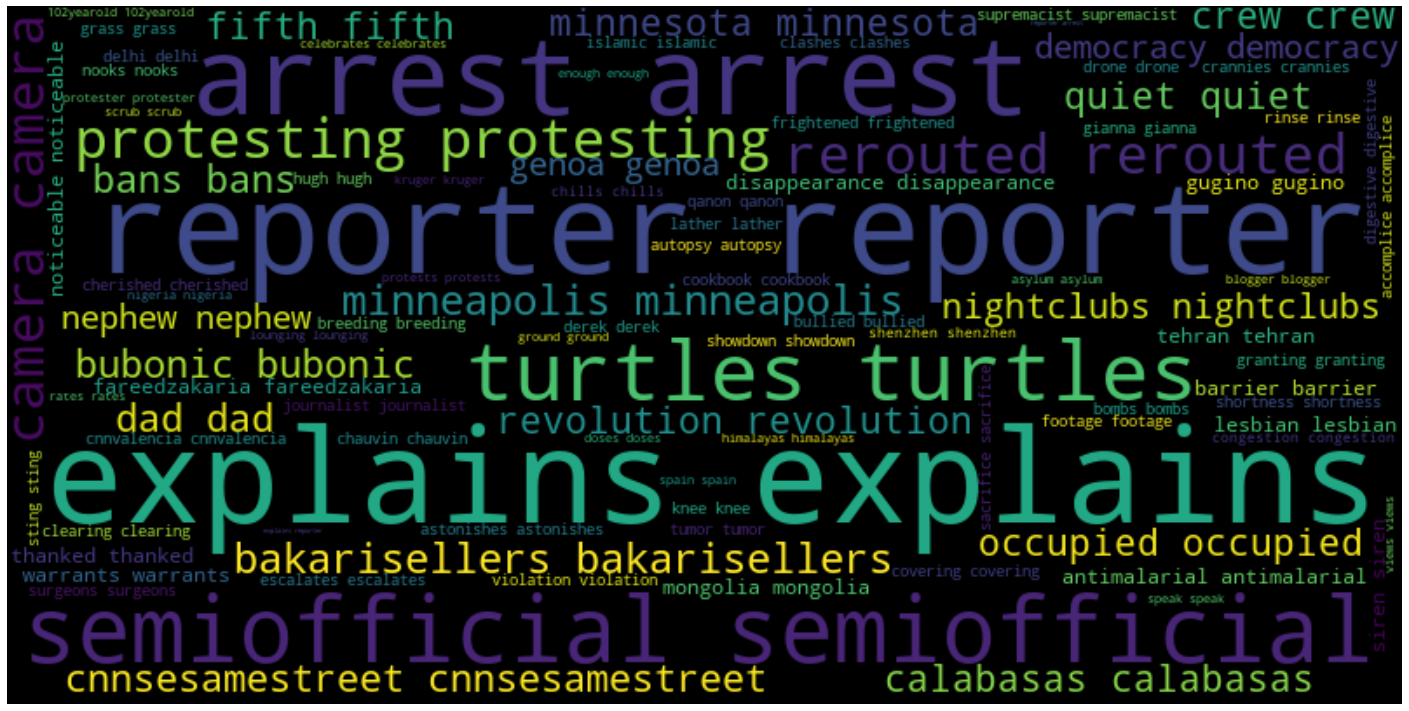

In [73]:
cloud = WordCloud(max_font_size=75, max_words=100, background_color="black", width=800, height=400).generate(wc)
# Creating Fig and flag size 
plt.figure(figsize=[25,15])
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()